In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np

# Ex 1

In [ ]:
x_train = torch.tensor([[0, 0], [0, 1], [1, 0], [1, 1]], dtype=torch.float32)
y_train = torch.tensor([[0], [1], [1], [0]], dtype=torch.float32)

In [ ]:
#define parameters
input_size = 2
hidden_size = 2
output_size = 1
learning_rate = 0.1
num_epochs = 10000

In [ ]:
#define weights and biases
w1 = torch.randn(input_size, hidden_size, dtype=torch.float32, requires_grad=True)
b1 = torch.randn(hidden_size, dtype=torch.float32, requires_grad=True)
w2 = torch.randn(hidden_size, output_size, dtype=torch.float32, requires_grad=True)
b2 = torch.randn(output_size, dtype=torch.float32, requires_grad=True)

In [10]:
def sigmoid(x, derivative=False):
    if derivative:
        return (torch.exp(-x))/((torch.exp(-x)+1)**2)
    return 1/(1 + torch.exp(-x))

In [ ]:
for epoch in range(num_epochs):
    z1 = torch.matmul(x_train, w1) + b1
    a1 = sigmoid(z1)
    z2 = torch.matmul(a1, w2) + b2
    a2 = sigmoid(z2)

    # Compute loss (MSE loss)
    loss = ((a2 - y_train) ** 2).mean()

    # Backward pass
    loss.backward()

    # Update weights and biases using gradient descent
    with torch.no_grad():
        w1 -= learning_rate * w1.grad
        b1 -= learning_rate * b1.grad
        w2 -= learning_rate * w2.grad
        b2 -= learning_rate * b2.grad

        # Reset gradients to zero
        w1.grad.zero_()
        b1.grad.zero_()
        w2.grad.zero_()
        b2.grad.zero_()

    if (epoch + 1) % 1000 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [1000/10000], Loss: 0.0631
Epoch [2000/10000], Loss: 0.0280
Epoch [3000/10000], Loss: 0.0164
Epoch [4000/10000], Loss: 0.0113
Epoch [5000/10000], Loss: 0.0084
Epoch [6000/10000], Loss: 0.0067
Epoch [7000/10000], Loss: 0.0055
Epoch [8000/10000], Loss: 0.0047
Epoch [9000/10000], Loss: 0.0040
Epoch [10000/10000], Loss: 0.0035


In [ ]:
with torch.no_grad():
    z1 = torch.matmul(x_train, w1) + b1
    a1 = torch.sigmoid(z1)
    z2 = torch.matmul(a1, w2) + b2
    predicted = torch.round(torch.sigmoid(z2))
    print(f'Predicted: {predicted.flatten()}')

Predicted: tensor([0., 1., 1., 0.])


# Ex 2

## Implement neural network with MNIST dataset

In [2]:
torch.manual_seed(42)

In [3]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(784, 256) #28x28 pixel images flattened to a vector of length 784
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 10) # final output is 10 digits 0-9

    def forward(self, x):
        x = torch.flatten(x, 1)
        x = sigmoid(self.fc1(x))
        x = sigmoid(self.fc2(x))
        x = self.fc3(x)
        return x

In [4]:
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.1307,), (0.3081,))]) #mean, std of mnist dataset

train_dataset = datasets.MNIST('mnist_data/', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST('mnist_data/', train=False, transform=transform)
#data = datasets.MNIST('mnist_data/',download=True, transform=transform)
#train_size = int(0.8 * len(data))
#test_size = len(data) - train_size
#train_dataset, test_dataset = torch.utils.data.random_split(data, [train_size, test_size])

100%|██████████| 9912422/9912422 [00:00<00:00, 90472256.54it/s]


Extracting mnist_data/MNIST/raw/train-images-idx3-ubyte.gz to mnist_data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 105703048.71it/s]


Extracting mnist_data/MNIST/raw/train-labels-idx1-ubyte.gz to mnist_data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 73037960.02it/s]

Extracting mnist_data/MNIST/raw/t10k-images-idx3-ubyte.gz to mnist_data/MNIST/raw


100%|██████████| 4542/4542 [00:00<00:00, 17209149.75it/s]


Extracting mnist_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to mnist_data/MNIST/raw



In [5]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)

In [18]:
def train(model, learning_rate, num_epochs):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=learning_rate)

    train_losses = []

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        for images, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * images.size(0)
        train_loss /= len(train_loader.dataset)
        train_losses.append(train_loss)

        if (epoch + 1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}')

    return train_losses

def test(model):
    criterion = nn.CrossEntropyLoss()
    model.eval()
    test_loss = 0.0
    correct = 0
    predictions = []
    true_labels = []

    with torch.no_grad():
        for images, labels in test_loader:
            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            predictions.extend(predicted.tolist())
            true_labels.extend(labels.tolist())

        test_loss /= len(test_loader.dataset)
        accuracy = correct / len(test_loader.dataset) * 100
        #binary_true_labels = [1 if label > 0 else 0 for label in true_labels]
        #binary_predictions = [1 if label > 0 else 0 for label in predictions]
        #f1 = f1_score(binary_true_labels, binary_predictions)
        #recall = recall_score(binary_true_labels, binary_predictions)

        predictions_np = np.array(predictions)
        true_labels_np = np.array(true_labels)
        TP = ((predictions_np == 1) & (true_labels_np == 1)).sum()
        FP = ((predictions_np == 1) & (true_labels_np == 0)).sum()
        FN = ((predictions_np == 0) & (true_labels_np == 1)).sum()
        precision = TP / (TP + FP)
        recall = TP / (TP + FN)
        f1_score = 2 * (precision * recall) / (precision + recall)
        #outputs = torch.tensor(predictions)
        #labels = torch.tensor(targets)

        #mse = test_loss
        #rmse = np.sqrt(mse)
        #mae = torch.abs(outputs - labels).float().mean()
        #mape = (torch.abs(outputs - labels) / labels).float().mean() * 100

    #print(f'MSE: {mse:.4f}')
    #print(f'RMSE: {rmse:.4f}')
    #print(f'MAE: {mae:.4f}')
    #print(f'MAPE: {mape:.2f}%')
    print(f'Accuracy: {accuracy:.2f}%')
    print(f"F1 score: {f1_score:.2}%")
    print(f"Recall: {recall:.2}%")
    return test_loss

## Different learning rates and loss graph

Epoch [10/10], Train Loss: 2.3388


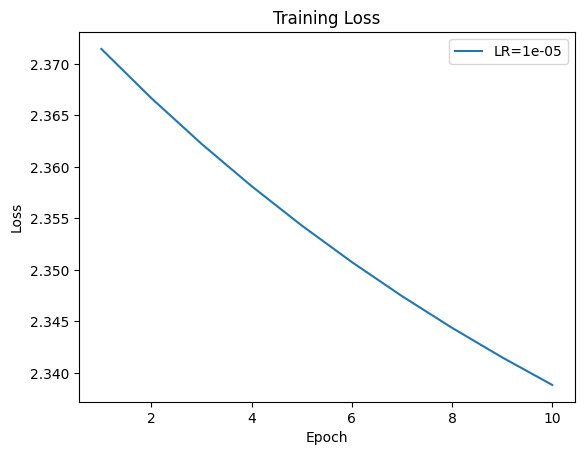

In [11]:
epochs = 10
lr = 0.00001
model1 = NeuralNetwork()
#train(model1, lr, epochs)

train_losses = train(model1, lr, epochs)

plt.plot(range(1, epochs+1), train_losses, label=f'LR={lr}')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()
plt.show()

Epoch [10/10], Train Loss: 0.1658


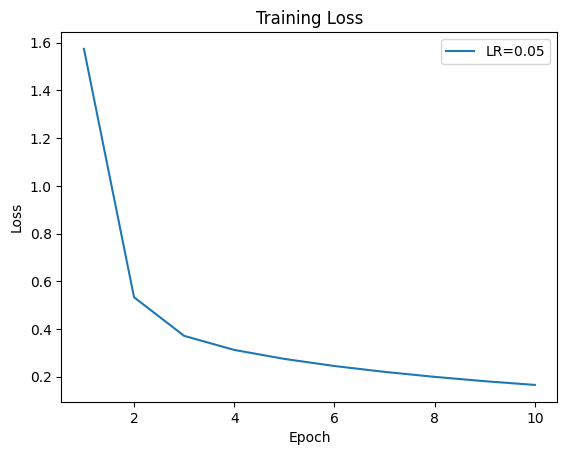

In [12]:
epochs = 10
lr = 0.05
model2 = NeuralNetwork()
train_losses = train(model2, lr, epochs)

plt.plot(range(1, epochs+1), train_losses, label=f'LR={lr}')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()
plt.show()

Epoch [10/10], Train Loss: nan


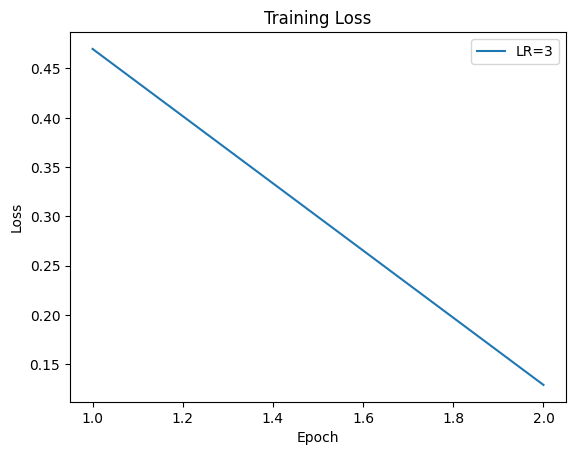

In [13]:
epochs = 10
lr = 3
model3 = NeuralNetwork()
train_losses = train(model3, lr, epochs)

plt.plot(range(1, epochs+1), train_losses, label=f'LR={lr}')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()
plt.show()

## Split train/test=80/20 and compute accuracy, f1, recall


In [14]:
train_dataset = datasets.MNIST('mnist_data/', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST('mnist_data/', train=False, transform=transform)
#data = datasets.MNIST('mnist_data/',download=True, transform=transform)
data = torch.utils.data.ConcatDataset([train_dataset, test_dataset])
train_size = int(0.8 * len(data))
test_size = len(data) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(data, [train_size, test_size])

In [15]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)

Epoch [10/10], Train Loss: 0.1755


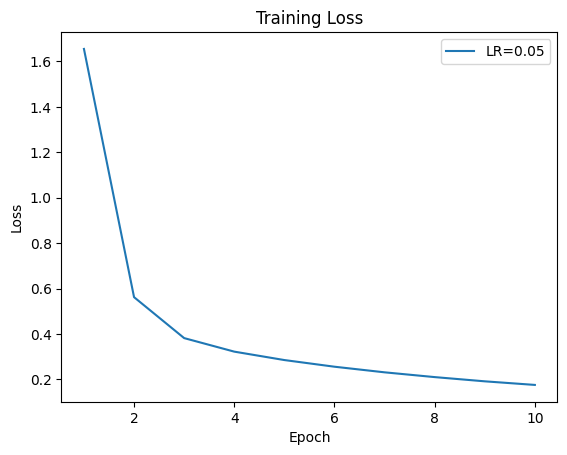

In [16]:
epochs = 10
lr = 0.05
model4 = NeuralNetwork()
train_losses = train(model4, lr, epochs)

plt.plot(range(1, epochs+1), train_losses, label=f'LR={lr}')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()
plt.show()

In [19]:
test(model4)

Accuracy: 94.47%
F1 score: 1.0%
Recall: 1.0%


0.19067677983215878

## Ex 3: Tại sao hàm softmax dùng exponential function? 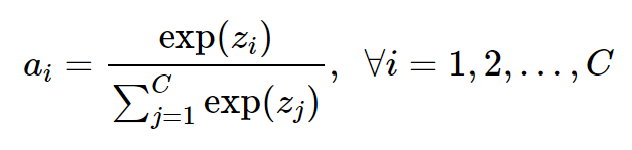

- Hàm mũ trả ra các giá trị không âm và có tổng = 1.
- Hàm mũ là hàm đồng biến.

Vì a(i) thể hiện xác suất các input rơi vào class i và hàm exponential sẽ đảm bảo được các giá trị xác suất đều dương và có tổng bằng 1. Ngoài ra, hàm mũ đồng biến nên hàm softmax cũng đồng biến, đảm bảo được khi input tăng thì xác suất trả ra cũng tăng.